In [6]:
using Plots, Statistics, Distributions, Random, ProgressMeter

In [2]:
# helper functions for the BEAM algorithm

function generate_midpoints(n_bins)
    quantiles = Array{Float64}(undef, n_bins)
    quantile_midpoints = Array{Float64}(undef, n_bins)

    #generate the quantile midpoints
    for i = 1:n_bins
        quantiles[i] = i/n_bins
        quantile_midpoints[i] = i/n_bins - (1/2)*(1/n_bins)
    end

    return vec(quantiles), vec(quantile_midpoints)
end

function add_distributions(list1, list2)
    sum_list = Array{Float64}(undef, length(list1)^2)
    
    list1 = repeat(list1, length(list1))
    list1 = sort(list1)
    list2 = repeat(list2, length(list2))
    
    for i in eachindex(sum_list)
        sum_list[i] = list1[i] + list2[i]
    end
    
    return vec(sort(sum_list))
end

function multiply_distributions(list1, list2)
    sum_list = Array{Float64}(undef, length(list1)^2)
    
    list1 = repeat(list1, length(list1))
    list1 = sort(list1)
    list2 = repeat(list2, length(list2))
    
    for i in eachindex(sum_list)
        sum_list[i] = list1[i] * list2[i]
    end
    
    return vec(sort(sum_list))
end

function re_bin(distribution, n_bins)
    rebinned = reshape(distribution, n_bins, n_bins)
    rebinned = mean(rebinned, dims = 1)
    
    return vec(rebinned)
end

function calculate_mean(RV, n_bins)
    return sum(RV .* 1/n_bins)
end

function calculate_variance(RV, calculated_mean, n_bins)
    return sum(RV.^2 * (1/n_bins)) - calculated_mean^2
end



function iid_exponential_BEAM(λ, RV_list, n_bins)
    n_RVs = length(RV_list)
    
    # define the list of quantiles and quantile midpoints
    quantiles, quantile_midpoints = generate_midpoints(n_bins)
    
    final_RV = first(RV_list)
    final_RV = quantile.(final_RV, quantile_midpoints)

    for i = 2:length(RV_list)
        temp_list = quantile.(RV_list[i], quantile_midpoints)

        final_RV = add_distributions(temp_list, final_RV)
        final_RV = re_bin(final_RV, n_bins) 
    end

    return final_RV
end

iid_exponential_BEAM (generic function with 1 method)

In [3]:
# helper functions for the Monte-Carlo simulation
function cumulative_average(list::Array)
    cumulative_averages = Array{Float64}(undef, length(list))
    cumulative_averages[1] = list[1]
    
    for i in 2:length(list)
        cumulative_averages[i] = mean(list[1:(i-1)])
    end
    
    return cumulative_averages
end

function cumulative_stddev(list::Array, Corrected::Bool)
    cumulative_stddevs = Array{Float64}(undef, length(list))
    cumulative_stddevs[1] = 0
    
    for i in 2:length(list)
        cumulative_stddevs[i] = std(list[1:(i-1)], corrected = Corrected)
    end
    
    return cumulative_stddevs
end

function cumulative_var(list::Array, Corrected::Bool)
    cumulative_var = Array{Float64}(undef, length(list))
    cumulative_var[1] = 0
    
    for i in 2:length(list)
        cumulative_var[i] = var(list[1:(i-1)], corrected = Corrected)
    end
    
    return cumulative_var
end


# simple Monte Carlo sim to evaluate sums of iid exponentials
function iid_exponential_montecarlo(λ, n_RVs, n_reps, multiplication::Bool)
    β = 1/λ
    
    dist = Exponential(β)
    output = Array{Float64}(undef, n_reps)
#     averages = Array{Float64}(undef, n_reps)
    
    for i in eachindex(output)
        RVs = rand(dist, n_RVs)
        if multiplication
            output[i] = prod(RVs)
        else
            output[i] = sum(RVs)
        end
    end
    
    return output
end


# simple Monte Carlo sim to evaluate the sums of iid normals
function iid_normals_montecarlo(μ, σ, n_RVs, n_reps, multiplication::Bool)
    dist = Normal(μ, σ)
    output = Array{Float64}(undef, n_reps)
    
    for i in eachindex(output)
        RVs = rand(dist, n_RVs)
        if multiplication
            output[i] = prod(RVs)
        else
            output[i] = sum(RVs)
        end
    end
    
    return output
end


# simple Monte Carlo sim to evaluate sums of non-iid normals
function non_iid_normals_montecarlo(μ̄::Array, σ̄::Array, n_reps, multiplication::Bool)
    n_RVs = length(μ̄)
    
    # instantiate a list of Random Variables based on the list
    #    of means and standard deviations and reshape into a 
    #    column vector
    dist_list = map(x -> Normal(x[1], x[2]), zip(μ̄, σ̄))
    
    output = Array{Float64}(undef, n_reps)
    
    for i = 1:n_reps
        random_draws = map(x -> rand(x), dist_list)
        if multiplication
            output[i] = prod(random_draws)
        else
            output[i] = sum(random_draws)
        end
    end
    
    return output
end

non_iid_normals_montecarlo (generic function with 1 method)

In [4]:
# helper functions for computing error vectors for both methods

function compute_variance_error(BEAM_variances::Array, montecarlo_variances::Array, true_variance::Number)
    BEAM_errors = BEAM_variances .- true_variance
    montecarlo_errors = montecarlo_variances .- true_variance
    
    return BEAM_errors, montecarlo_errors
end

function compute_averages_error(BEAM_means::Array, montecarlo_means::Array, true_mean::Number)
    BEAM_errors = BEAM_means .- true_mean
    montecarlo_errors = montecarlo_means .- true_mean
    
    return BEAM_errors, montecarlo_errors
end

compute_averages_error (generic function with 1 method)

In [7]:
# main code, edit these values for different comparisons between the methods:

n_replications = 1000
n_RVs = 30

λ = 4

true_mean = n_RVs/λ
true_var = n_RVs/λ^2

# minimum number of bins = 4
BEAM_convolution = Array{Float64}(undef, n_replications - 3)
BEAM_variances = Array{Float64}(undef, n_replications - 3)

# instantiate a list of iid RVs to avoid creating them in memory for each BEAM loop
β = 1/λ
RV_list = Array{Distribution}(undef, n_RVs)
RV_list = [Exponential(β) for i = 1:n_RVs]

# loop through BEAM process with an increasing number of bins from 4 - n_replications
@showprogress "Computing BEAM convolutions" for i = 4:n_replications
    RV = iid_exponential_BEAM(λ, RV_list, i)
    BEAM_convolution[i - 3] = calculate_mean(RV, i)
    BEAM_variances[i - 3] = calculate_variance(RV, BEAM_convolution[i - 3], i)
end

# generate Monte Carlo results
Corrected = false
multiply = false
montecarlo_convolutions = iid_exponential_montecarlo(λ, n_RVs, n_replications, multiply)
montecarlo_variances = cumulative_var(montecarlo_convolutions, Corrected)
montecarlo_convolutions = cumulative_average(montecarlo_convolutions)

# compute error vectors
BEAM_var_error, montecarlo_var_error = compute_variance_error(BEAM_variances, 
                                                              montecarlo_variances, 
                                                              true_var);
BEAM_mean_error, montecarlo_mean_error = compute_averages_error(BEAM_convolution, 
                                                                montecarlo_convolutions, 
                                                                true_mean);

Computing BEAM convolutions100%|████████████████████████| Time: 0:15:21


In [8]:
#shifting the BEAM vectors since the minimum number of bins is 4
BEAM_var_error = vcat([NaN, NaN, NaN], BEAM_var_error)
BEAM_mean_error = vcat([NaN, NaN, NaN], BEAM_mean_error);
println(length(BEAM_mean_error))
println(length(montecarlo_mean_error))

1000
1000


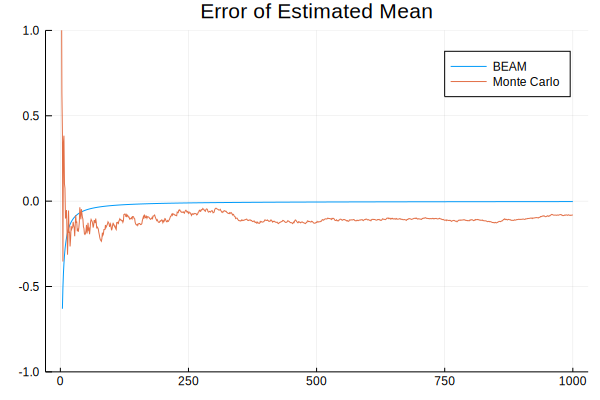

In [9]:
plot(BEAM_mean_error, title = "Error of Estimated Mean", label = "BEAM", ylim = (-1,1))
plot!(montecarlo_mean_error, label = "Monte Carlo")

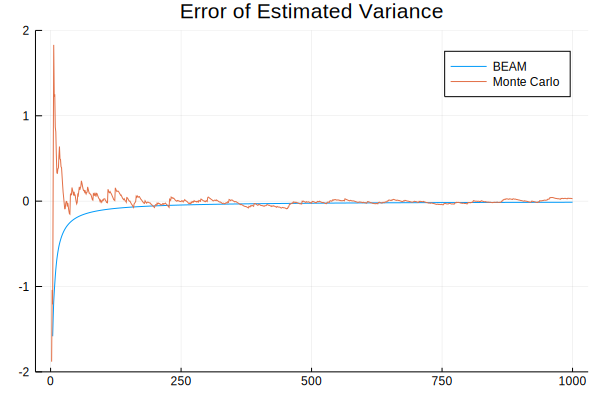

In [10]:
plot(BEAM_var_error, title = "Error of Estimated Variance", label = "BEAM", ylim = (-2, 2))
plot!(montecarlo_var_error, label = "Monte Carlo")

In [11]:
empirical_mean_BEAM = last(BEAM_convolution)
empirical_variance_BEAM = last(BEAM_variances)

empirical_mean_montecarlo = last(montecarlo_convolutions)
empirical_variance_montecarlo = last(montecarlo_variances)

println("True average (n/λ): ", n_RVs/λ)
println("True variance (n/λ^2): ", n_RVs/(λ^2))
println("Computed average (BEAM): ",empirical_mean_BEAM)
println("Computed variance (BEAM): ", empirical_variance_BEAM)
println("Computed average (Monte Carlo): ", empirical_mean_montecarlo)
println("Computed variance (Monte Carlo): ", empirical_variance_montecarlo)

True average (n/λ): 7.5
True variance (n/λ^2): 1.875
Computed average (BEAM): 7.497401010572886
Computed variance (BEAM): 1.8620223815088508
Computed average (Monte Carlo): 7.419592728121675
Computed variance (Monte Carlo): 1.9036714710188847


In [12]:
# the following plots require the StatsPlots package

# plot(Gamma(n_RVs, 1/λ), label="Gamma")
# plot!(Normal(empirical_mean_BEAM, empirical_variance_BEAM^0.5), label = "BEAM Normal")
# plot!(Normal(empirical_mean_montecarlo, empirical_variance_montecarlo^0.5), label = "Monte Carlo Normal")
# plot!(Normal(true_mean, sqrt(true_var)), label = "CLT Normal")